# Données orlane


In [1]:
# liste des imports
import pandas as pd
import numpy as np
import sklearn
from matplotlib import pyplot as plt
import xgboost as xgb

In [2]:
### en l'attente des vraies données, créer les données
variables=['n_cycles','type','armure','n_couches','jauge','masse','compo','n_rangées','n_colonnes','perméabilité','efficacité']
data=pd.DataFrame(np.random.randint(0,100,size=(100,len(variables))),columns=variables)
data['n_cycles']=np.random.choice([0,5,15,20,25,30,40,50],100)
data['type']=np.random.choice([0,1,2,3],100) # arbitrairement 0 = tissu, 1= tricot, 2= non-tissé, 3=complexe
data['armure']=np.random.choice([np.nan,0,1,2],100)#0=toile, 1=jersey,2=toile
data['n_couches']=np.random.choice([1,2,3,4],100)
data['jauge']=np.random.choice([1,2,np.nan],100)
data['masse']=np.random.rand(100,1)
data['compo']=np.random.choice([1,2,3,4],100) #variable inexploitable en l'etat, enventuellement si peu de composants, diviser en varaibles de chaque % de compo
data['n_rangées']=np.random.choice([1,2,3,4],100)
data['n_colonnes']=np.random.choice([1,2,3,4],100)
data['perméabilité']=np.random.random(100)
data['efficacité']=np.random.random(100)

data.head()


,n_cycles,type,armure,n_couches,jauge,masse,compo,n_rangées,n_colonnes,perméabilité,efficacité
0,20,2,2.0,1,2.0,0.539031,2,1,4,0.941074,0.377506
1,50,2,1.0,3,2.0,0.740598,2,4,3,0.854020,0.841266
2,20,2,0.0,4,NaN,0.811403,1,2,1,0.277717,0.334862
3,15,0,1.0,1,2.0,0.599550,2,3,3,0.451361,0.128561
4,30,3,1.0,3,NaN,0.737812,4,2,1,0.444834,0.763254


# Resoudre pb données
On va garder le fichier data brut comme ça au cas où, mais on va créer un ficher netoyé des input problématiqued

## types de données: 
### qualitatives= type, compo, armure, jauge
### quantitative discrètes = n_cycle, n_couches, n_rangées, n_colonnes
### quantitative continues= masse, perméabilité, efficacité

In [3]:
# eliminer les variables non complètes
data_raw=data #archiver les données brutes dans raw

data=data_raw.dropna(axis=1) #axis=1 veut dire qu'on elimine les colonnes et non pas les evenement

#eliminer les type complexes qui risquent de perturber l'analyse
data=data[data['type']!=3]


# on crée aussi un fichier par type de data, plus pratique pour plus tard
data_tricot=data[data['type']==1]
data_tisse=data[data['type']==0]
data_tisse=data[data['type']==2]


#pb nb rangées et colonnes diff si tissus, tricot ou autre, pour le moment je fais rien mais dans l'analyse inclusive de tous les types a mon avis faut pas utiliser ces variables
#idem, oublier compo pour le moment

data.head()


,n_cycles,type,n_couches,masse,compo,n_rangées,n_colonnes,perméabilité,efficacité
0,20,2,1,0.539031,2,1,4,0.941074,0.377506
1,50,2,3,0.740598,2,4,3,0.854020,0.841266
2,20,2,4,0.811403,1,2,1,0.277717,0.334862
3,15,0,1,0.599550,2,3,3,0.451361,0.128561
5,40,2,3,0.083245,3,1,2,0.158797,0.374326


In [4]:
#stats sur les données
min=data.min().values
max=data.max().values
mean=data.mean().values
std=data.std().values
ar=np.array([min, max, mean, std])
stats=pd.DataFrame(ar, index=['min','max','mean','std'],columns=data.columns)
stats

,n_cycles,type,n_couches,masse,compo,n_rangées,n_colonnes,perméabilité,efficacité
min,0.000000,0.000000,1.000000,0.016145,1.000000,1.000000,1.000000,0.000830,0.010526
max,50.000000,2.000000,4.000000,0.970716,4.000000,4.000000,4.000000,0.997084,0.993037
mean,22.250000,0.962500,2.762500,0.465658,2.462500,2.587500,2.650000,0.543145,0.539519
std,14.966207,0.833534,1.046317,0.294018,1.124455,1.176712,1.126212,0.290945,0.273985


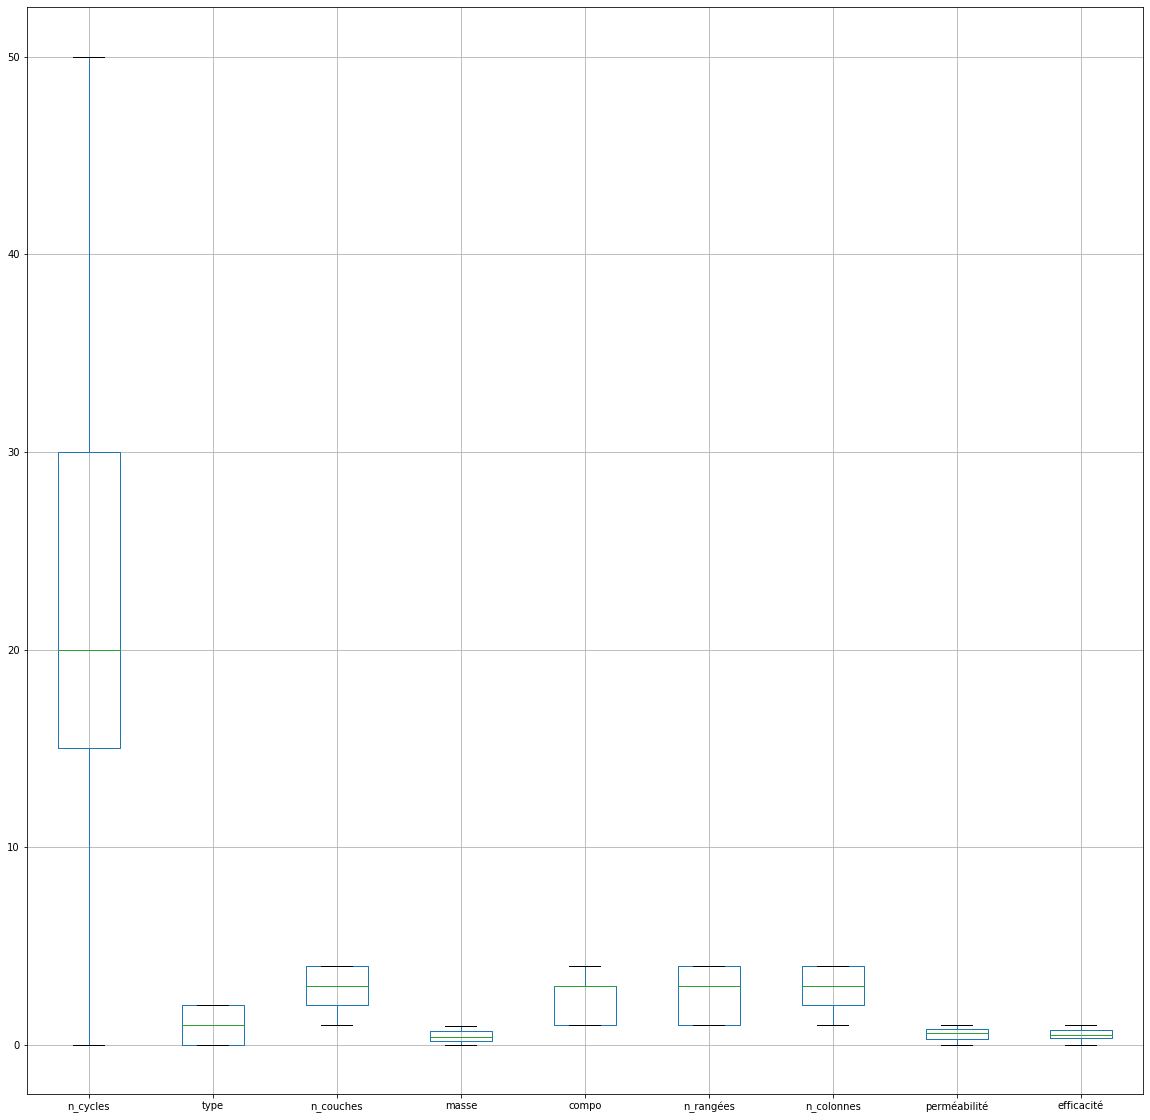

In [5]:
#visualiser repart variables
box=data.boxplot(figsize=(20,20))

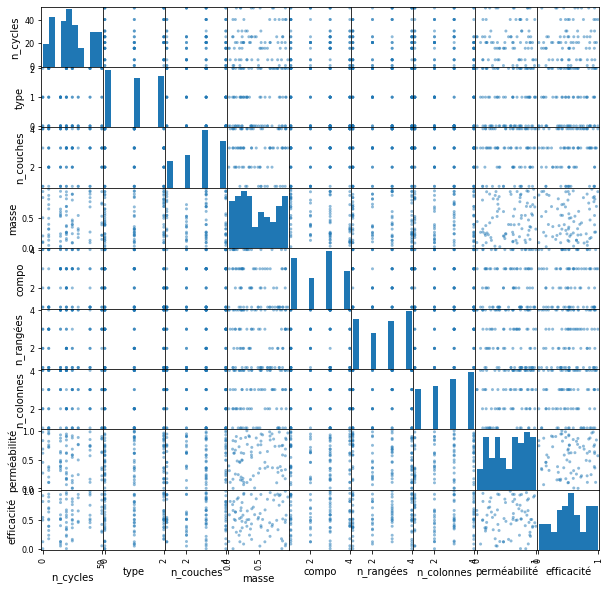

In [6]:
#visualiser corrélations entre variables

plot=pd.plotting.scatter_matrix(frame=data, figsize=(10,10))

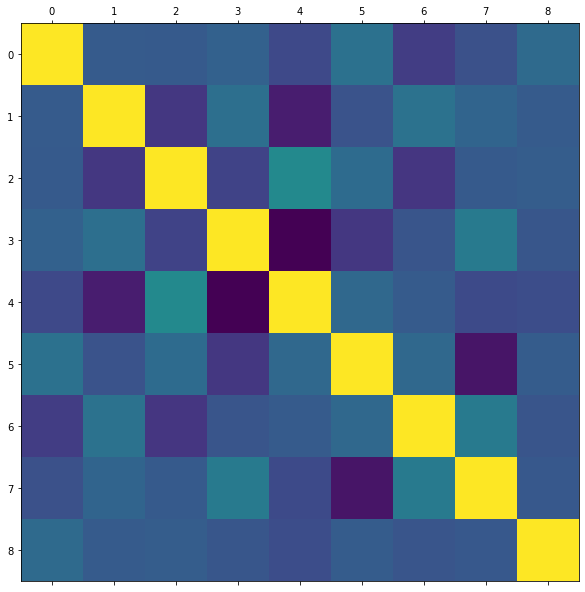

In [7]:
#autre visualisation des corrélations
corr=data.corr()
plt.figure(figsize=(10,10))
plt.matshow(corr, fignum=1)

# L'objectif est maintenant de determiner les variables ayant l'impact le plus élevé sur la determination de l'efficacité


Ici, on a un pb de régression (à multiples variables)

## essai1 : xgboost

import xgboost as xgb

#pour que les méthode de ML soient efficaces, il vaut mieux que chaque varaibles soient normalisées, mais pas sur que ce soit nécessaire ici
from sklearn import preprocessing
sc=preprocessing.StandardScaler()
data_norm=sc.fit_transform(data)
data_norm=pd.DataFrame(data_norm, columns=data.keys())


In [8]:
#choisir les features a étudier
features=['n_cycles', 'type', 'n_couches', 'masse','n_rangées', 'n_colonnes'] #enlevé compo car pas claires et permé car données finale mais on peut rajouter
target='efficacité' #choisir la variable objectif, ici efficacité, eventuellemnt permé, à terme tu pourras choisir l'eff à telle granu
X,y=data[features], data[target] 


#maintenant, séparer en fichier d'entrainement (80%) et test)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)


#On utilise les DMatrix pour gagner en perf
train=xgb.DMatrix(data=X_train,label=y_train)
test=xgb.DMatrix(data=X_test,label=y_test)



In [14]:
#on crée le modèle
from sklearn.metrics import explained_variance_score
model = xgb.XGBRegressor(colsample_bytree=0.8, 
                 gamma=0,                 
                 learning_rate=0.05,
                 max_depth=3,
                 min_child_weight=1,
                 n_estimators=1000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.8,
                 verbosity=1,
                 seed=42) 

model.fit(X_train, y_train) #fit model to train data

#now we predict on test set
predictions = model.predict(X_test)
print(explained_variance_score(predictions,y_test))

-5.233494804801753


<BarContainer object of 6 artists>

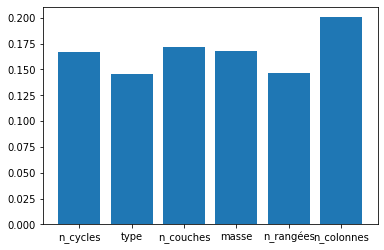

In [15]:
#plotting feature importance

importance=model.feature_importances_

plt.bar(features, importance)

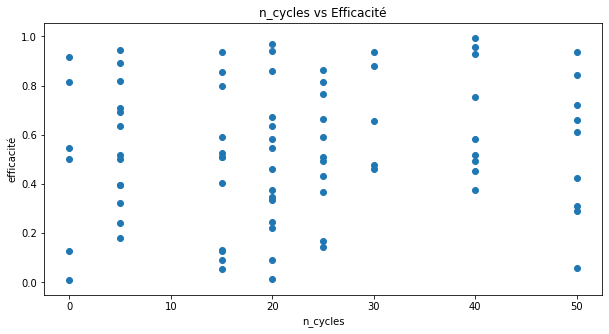

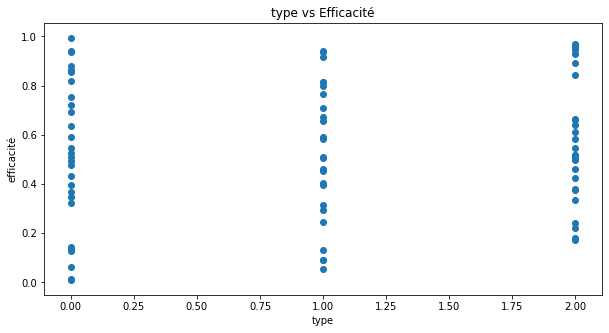

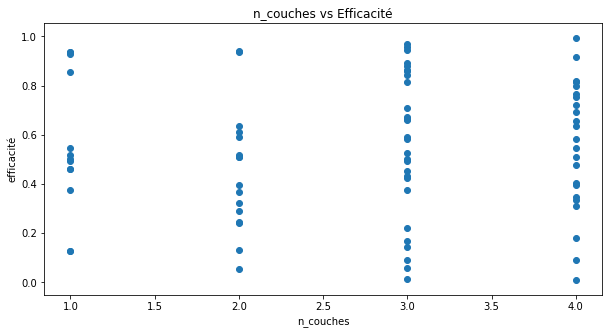

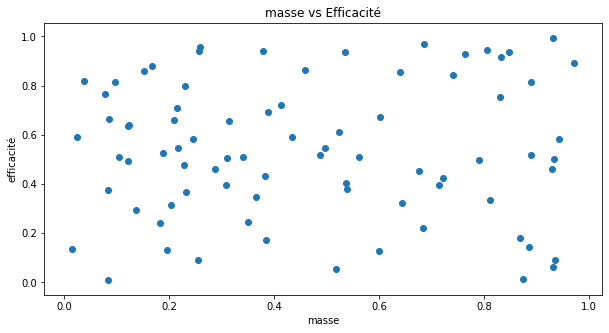

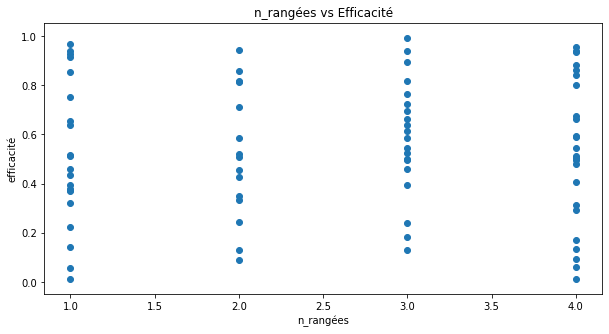

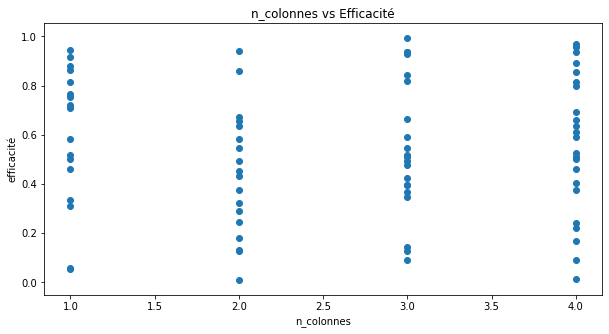

In [11]:
#plotting efficacité(variable)

for var in features:
    plt.figure(figsize=(10,5))
    plt.scatter(X[var],y)
    plt.title("{} vs Efficacité".format(var))
    plt.xlabel(var)
    plt.ylabel('efficacité')